# Part 3C: MNIST CNN with TensorFlow (GradientTape)

_Author: Suyog Garg_, _Dated: 2025/11/18_



This notebook uses **TensorFlow Core** with an explicit training loop (`tf.GradientTape`).  
We still use Keras layers for convenience, but control the optimization ourselves.


## Environment

In [1]:
import os, sys, time, json, pathlib
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
print("TensorFlow:", tf.__version__)
print("Devices:", tf.config.list_physical_devices())


TensorFlow: 2.20.0
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]



## Dataset & preprocessing

We use **MNIST** (28×28 grayscale digits, 10 classes). Input is normalized to `[0, 1]`
and reshaped to `(N, 28, 28, 1)` for CNNs. Labels are integers `0..9`.

We also create a `tf.data.Dataset` pipeline.

In [2]:
from tensorflow.keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32")/255.0
x_test  = x_test.astype("float32")/255.0
x_train = np.expand_dims(x_train, -1)
x_test  = np.expand_dims(x_test, -1)

BATCH=128
train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(BATCH)
val_ds   = tf.data.Dataset.from_tensor_slices((x_test,  y_test)).batch(BATCH)

## Model + custom train loop

In [3]:
def build_model():
    inputs = keras.Input(shape=(28,28,1))
    x = layers.Conv2D(32, 3, activation="relu")(inputs)
    x = layers.Conv2D(64, 3, activation="relu")(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.25)(x)
    x = layers.Flatten()(x)
    x = layers.Dense(128, activation="relu")(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return keras.Model(inputs, outputs)

model = build_model()
optimizer = keras.optimizers.Adam(1e-3)
loss_fn = keras.losses.SparseCategoricalCrossentropy()
train_loss_hist, val_loss_hist, val_acc_hist = [], [], []

In [4]:
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss = loss_fn(y, logits)
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss

@tf.function
def val_step(x, y):
    preds = model(x, training=False)
    loss = loss_fn(y, preds)
    acc  = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(preds, axis=1), tf.cast(y, tf.int64)), tf.float32))
    return loss, acc

In [5]:
EPOCHS=5
t0=time.perf_counter()
for epoch in range(EPOCHS):
    # train
    lsum=0.0; n=0
    for x,y in train_ds:
        l = train_step(x,y)
        lsum += float(l); n += 1
    train_loss_hist.append(lsum/max(n,1))
    # val
    lsum=0.0; asum=0.0; n=0
    for x,y in val_ds:
        l,a = val_step(x,y)
        lsum += float(l); asum += float(a); n += 1
    val_loss_hist.append(lsum/max(n,1))
    val_acc_hist.append(asum/max(n,1))
    print(f"Epoch {epoch+1}/{EPOCHS} - loss {train_loss_hist[-1]:.4f} - val_loss {val_loss_hist[-1]:.4f} - val_acc {val_acc_hist[-1]:.4f}")
train_time = time.perf_counter()-t0

2025-11-18 22:37:41.762291: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-18 22:37:42.991451: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 1/5 - loss 0.1610 - val_loss 0.0460 - val_acc 0.9841


2025-11-18 22:38:10.977530: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2/5 - loss 0.0462 - val_loss 0.0412 - val_acc 0.9856
Epoch 3/5 - loss 0.0316 - val_loss 0.0338 - val_acc 0.9895


2025-11-18 22:39:07.388531: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 4/5 - loss 0.0216 - val_loss 0.0352 - val_acc 0.9892
Epoch 5/5 - loss 0.0186 - val_loss 0.0302 - val_acc 0.9905


## Curves

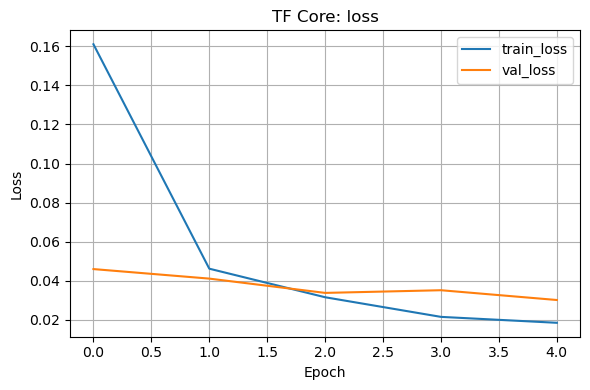

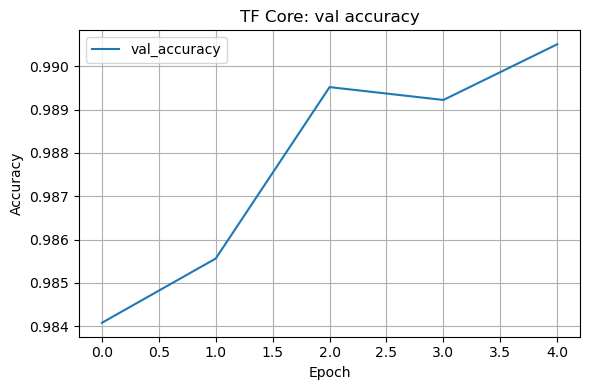

In [6]:
plt.figure(figsize=(6,4))
plt.plot(train_loss_hist, label="train_loss")
plt.plot(val_loss_hist, label="val_loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.grid(True); plt.title("TF Core: loss")
plt.tight_layout()
plt.savefig("artifacts/tfcore_loss.png", dpi=150)
plt.show()

plt.figure(figsize=(6,4))
plt.plot(val_acc_hist, label="val_accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.grid(True); plt.title("TF Core: val accuracy")
plt.tight_layout()
plt.savefig("artifacts/tfcore_acc.png", dpi=150)
plt.show()

## Evaluate & save metrics

In [7]:
# Utility: save artifacts (plots & metrics)
import os, json, pathlib, time
ART = pathlib.Path("artifacts")
ART.mkdir(exist_ok=True)

In [8]:
def save_metrics(name, **metrics):
    path = ART / f"{name}_metrics.json"
    with open(path, "w") as f:
        json.dump(metrics, f, indent=2)
    print("Saved:", path)

def effective_loc(*funcs):
    import inspect
    n = 0
    for f in funcs:
        try:
            src = inspect.getsource(f)
            for line in src.splitlines():
                s = line.strip()
                if s and not s.startswith("#"):
                    n += 1
        except Exception:
            pass
    return n

In [11]:
# Final evaluation on test set
test_logits = model.predict(x_test, verbose=0)
test_preds = test_logits.argmax(axis=1)
test_acc = float(np.mean(test_preds == y_test))
test_loss = float(tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_test, test_logits)).numpy())

save_metrics("tfcore", framework="tensorflow", test_accuracy=test_acc, test_loss=test_loss,
             train_time_sec=float(train_time), params=int(model.count_params()), epochs=len(val_loss_hist),
             device=str(tf.config.list_physical_devices("GPU") or tf.config.list_physical_devices("CPU")),
             effective_loc=int(effective_loc(build_model, train_step, val_step)))
model.save("artifacts/tensorflow_mnist.keras")
print("Saved artifacts/ and metrics.")

Saved: artifacts/tfcore_metrics.json
Saved artifacts/ and metrics.
